# 프로젝트 개요
- 강의명 : 2022년 K-디지털 직업훈련(Training) 사업 - AI데이터플랫폼을 활용한 빅데이터 분석전문가 과정
- 교과목명 : 빅데이터 분석 및 시각화, AI개발 기초, 인공지능 프로그래밍
- 프로젝트 주제 : Ubiquant Market 데이터를 활용한 미래 투자 예측
- 프로젝트 마감일 : 2022년 4월 12일 화요일
- 강사명 : 정지훈 강사
- 수강생명 : 정진우

# Step 1. 라이브러리 불러오기
- 본 프로젝트 수행을 위한 필수 라이브러리를 불러온다.

In [1]:
# 데이터 가공
import pandas as pd
import numpy as np

# 메모리 정리
import gc

# for문 진행상황 확인
from tqdm.auto import tqdm

# 데이터 시각화
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats

# Step 2. 데이터 불러오기 및 용량 축소

- 주어진 데이터의 행은 3141410 개, 열은 304 개로 구성되어 있음.
- 데이터는 독립변수 컬럼 갯수는 303개이며, 종속 변수 컬럼은 1개로 구성되어 있음.

- Ubiquant에서 제공하는 데이터 train.csv는 용량이 18.55 GB 
- Kaggle에서 제공하는 RAM의 크기는 16 GB
- 입력 데이터에 크기가 RAM의 크기보다 높아, 입력데이터 실행시 RAM에 과부하가 일어나므로, 입력데이터의 크기를 줄이는 것이 불가피.

- dtypes라는 이름의 dict을 이용하여 train.csv에 있는 각 feature들의 datatype들을 다른 타입으로 지정.
    - row_id -> str
    - time_id -> uint16
    - investment_id -> uint16
    - target -> float32
    - f_0 ~ f_299 -> float32

In [2]:
# setting reading types
dtypes = {
    "row_id" : "str",
    "time_id" : "uint16",
    "investment_id" : "uint16",
    "target " : 'float32',    
}
for i in range(300):
    dtypes[f'f_{i}'] = 'float32'

In [3]:
%%time
train_df = pd.read_csv("../input/ubiquant-market-prediction/train.csv", dtype=dtypes)
train_df.head()

CPU times: user 4min 10s, sys: 21.1 s, total: 4min 31s
Wall time: 6min 48s


,row_id,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,0_1,0,1,-0.300875,0.932573,0.113691,-0.402206,0.378386,-0.203938,-0.413469,...,0.366028,-1.095620,0.200075,0.819155,0.941183,-0.086764,-1.087009,-1.044826,-0.287605,0.321566
1,0_2,0,2,-0.231040,0.810802,-0.514115,0.742368,-0.616673,-0.194255,1.771210,...,-0.154193,0.912726,-0.734579,0.819155,0.941183,-0.387617,-1.087009,-0.929529,-0.974060,-0.343624
2,0_6,0,6,0.568807,0.393974,0.615937,0.567806,-0.607963,0.068883,-1.083155,...,-0.138020,0.912726,-0.551904,-1.220772,-1.060166,-0.219097,-1.087009,-0.612428,-0.113944,0.243608
3,0_7,0,7,-1.064780,-2.343535,-0.011870,1.874606,-0.606346,-0.586827,-0.815737,...,0.382201,0.912726,-0.266359,-1.220772,0.941183,-0.609113,0.104928,-0.783423,1.151730,-0.773309
4,0_8,0,8,-0.531940,0.842057,-0.262993,2.330030,-0.583422,-0.618392,-0.742814,...,-0.170365,0.912726,-0.741355,-1.220772,0.941183,-0.588445,0.104928,0.753279,1.345611,-0.737624


- memory leakage 해결을 위해 코드 실행 후 garbage collector를 실행.

In [4]:
gc.collect()

21

- datatype 변환 후의 입력 데이터의 용량
    - 변환 전 : 18.55 GB
    - 변환 후 : 3.6+ GB

In [5]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3141410 entries, 0 to 3141409
Columns: 304 entries, row_id to f_299
dtypes: float32(300), float64(1), object(1), uint16(2)
memory usage: 3.6+ GB
None


- 이렇게 변환된 입력데이터를 이용해 어려 전처리 과정들을 시도하였지만, 축속된 입력데이터도 과정 중에 RAM에 memory leakage를 일으켜 RAM에 memory error를 일으킴.
- 추가적인 데이터 용량 축소가 필요.

- 1차 변환된 입력데이터의 각 feature들의 datatype들을 기존의 datatype들을 다른 형식으로 지정.
    - row_id -> category
    - time_id -> int16
    - investment_id -> int16
    - target -> float16
    - f_0 ~ f_299 -> float16

In [6]:
def reduce_memory_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2 # Unit: MB
    print('Memory usage of input dataframe: {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        # categorical data
        if col_type == object:
            df[col] = df[col].astype('category')
        # numerical data
        else:
            c_min = df[col].min()
            c_max = df[col].max()
            # integer
            if str(col_type)[:3] == 'int' or str(col_type)[:4] == 'uint':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            # float
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

- 2차 변환 후 입력 데이터의 용량 
    - 1차 전 : 18.55 GB
    - 1차 후 : 3.6+ GB
    - 2차 후 : 1.9 GB

In [7]:
train_df_1 = reduce_memory_usage(train_df)

del train_df
gc.collect()

Memory usage of input dataframe: 3654.98 MB
Memory usage after optimization: 1915.96 MB
Decreased by 47.6%


0

In [8]:
train_df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3141410 entries, 0 to 3141409
Columns: 304 entries, row_id to f_299
dtypes: category(1), float16(301), int16(2)
memory usage: 1.9 GB


- 최종 변환된 dataset을 빠르게 불러올 수 있는 pickle 형식으로 저장.

In [9]:
train_df_1.to_pickle('train_df.pkl')

- 저장된 pickle 형식으로 데이터를 불러옴.

In [10]:
%%time
train_df = pd.read_pickle("./train_df.pkl")
train_df.head()

CPU times: user 802 ms, sys: 646 ms, total: 1.45 s
Wall time: 1.45 s


,row_id,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,0_1,0,1,-0.300781,0.932617,0.113708,-0.402100,0.378418,-0.203979,-0.413574,...,0.365967,-1.095703,0.200073,0.819336,0.941406,-0.086792,-1.086914,-1.044922,-0.287598,0.321533
1,0_2,0,2,-0.231079,0.811035,-0.514160,0.742188,-0.616699,-0.194214,1.771484,...,-0.154175,0.912598,-0.734375,0.819336,0.941406,-0.387695,-1.086914,-0.929688,-0.974121,-0.343506
2,0_6,0,6,0.568848,0.394043,0.615723,0.567871,-0.607910,0.068909,-1.083008,...,-0.138062,0.912598,-0.551758,-1.220703,-1.060547,-0.219116,-1.086914,-0.612305,-0.113953,0.243652
3,0_7,0,7,-1.064453,-2.343750,-0.011871,1.875000,-0.606445,-0.586914,-0.815918,...,0.382080,0.912598,-0.266357,-1.220703,0.941406,-0.608887,0.104919,-0.783203,1.151367,-0.773438
4,0_8,0,8,-0.531738,0.842285,-0.262939,2.330078,-0.583496,-0.618164,-0.742676,...,-0.170410,0.912598,-0.741211,-1.220703,0.941406,-0.588379,0.104919,0.753418,1.345703,-0.737793


In [11]:
del train_df_1
gc.collect()

21

- 새로 불러온 데이터를 불러오기 전의 데이터 정보와 비교한다.
- 비교 결과 용량과 데이터 형식의 변화만 있을 뿐 다른 변화는 없는 것으로 확임됨.
- 최종 데이터 형식 구성은 category(1), float16(301), int16(2)로 구성됨.

In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3141410 entries, 0 to 3141409
Columns: 304 entries, row_id to f_299
dtypes: category(1), float16(301), int16(2)
memory usage: 1.8 GB


- 결측치 여부를 확인한 결과 없는 것으로 확임됨. 

In [13]:
train_df.isnull().sum()

row_id           0
time_id          0
investment_id    0
target           0
f_0              0
                ..
f_295            0
f_296            0
f_297            0
f_298            0
f_299            0
Length: 304, dtype: int64

# Step 3. 탐색적 자료 분석(EDA)

- 입력 데이터 정보
    - 총 304개의 컬럼들을 포함하고, 300개의 feature들은 전부 이름이 익명화됨. 
        - 익명화되 있기 때문에 data의 feature에 따른 분석이 힘들고, 다른 조사 자료를 통한 추가지표 생성이 불가능.
    - dataset 내에 Null value가 존재하지 않음. 
        - 전처리 과정의 난이도 하락.
    - target 분석에 초점을 맞춰야 됨. 

- dataset 정보
    - row_id - A unique identifier for the row.
    - time_id - The ID code for the time the data was gathered. The time IDs are in order, but the real time between the time IDs is not constant and will likely be shorter for the final private test set than in the training set.
    - investment_id - The ID code for an investment. Not all investment have data in all time IDs.
    - target - The target.
    - [f_0:f_299] - Anonymized features generated from market data.

- row_id 는 단순한 행의 번호이므로 분석에는 필요하지 않음. 

- 각 컬럼들을 개수로 파악할 때, 각 컬럼별로 집중되는 구간이 있다는 것을 확인.

In [14]:
train_df['time_id'].value_counts()

1214    3445
1209    3444
1211    3440
1207    3440
1208    3438
        ... 
415      659
362      651
374      600
398      539
492      512
Name: time_id, Length: 1211, dtype: int64

In [15]:
train_df['investment_id'].value_counts()

2140    1211
2385    1209
1062    1209
1144    1209
2727    1209
        ... 
905        8
2558       8
3662       7
2800       3
1415       2
Name: investment_id, Length: 3579, dtype: int64

In [16]:
train_df['target'].value_counts()

 0.000000    1736
-0.516602     840
-0.519531     819
-0.500488     813
-0.512207     812
             ... 
-0.002434       1
-0.001189       1
 0.001925       1
 7.582031       1
-0.001307       1
Name: target, Length: 29121, dtype: int64

In [17]:
train_df['f_1'].value_counts()

-0.707031    1277
 1.054688    1170
-1.003906    1159
-0.607422    1155
-0.705566    1154
             ... 
 0.006428       1
 0.001370       1
-0.000820       1
-0.000413       1
 0.000885       1
Name: f_1, Length: 24719, dtype: int64

- describe() 함수 적용
    - 적용된 내용을 보면 몇 컬럼의 mean값에 NaN이 표시가 되어있는 데, 이는 계산된 데이터형식이 float16이기 때문. 
    - flaot16형식에서 mean계산을 할 경우 데이터 형식이 이를 받아들이지 못해 NaN으로 반환됨.
    - 향우 mean계산이 필요시 float32형식으로 일시적 변환이 필요함.

In [18]:
train_df.describe()

,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,f_6,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
count,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,...,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06
mean,6.654862e+02,1.885265e+03,NaN,1.633644e-03,-1.258850e-02,8.499146e-03,-1.992798e-02,-5.428314e-03,-3.021240e-03,1.940727e-03,...,1.258850e-02,8.964539e-04,-6.500244e-03,2.836227e-03,-4.730225e-03,NaN,-1.508713e-03,-7.053375e-03,-4.215240e-03,-4.329681e-03
std,3.560434e+02,1.083616e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
min,0.000000e+00,0.000000e+00,-9.421875e+00,-1.765625e+01,-6.578125e+00,-8.640625e+00,-1.800000e+01,-4.000000e+00,-8.835938e+00,-6.382812e+00,...,-9.273438e+00,-6.359375e+00,-8.187500e+00,-2.400000e+01,-1.497656e+01,-9.351562e+00,-7.367188e+00,-7.578125e+00,-6.707031e+00,-1.028125e+01
25%,3.530000e+02,9.520000e+02,-5.004883e-01,-4.072266e-01,-6.811523e-01,-6.533203e-01,-4.497070e-01,-3.532715e-01,-7.070312e-01,-7.910156e-01,...,-6.035156e-01,-8.354492e-01,-6.982422e-01,-1.376953e-01,-9.399414e-01,-5.146484e-01,-9.575195e-01,-7.241211e-01,-8.164062e-01,-5.078125e-01
50%,7.040000e+02,1.882000e+03,-9.716797e-02,2.431641e-01,-4.867554e-02,4.351807e-02,-2.639160e-01,-1.909180e-01,-2.145386e-02,1.438141e-02,...,6.085205e-02,-2.022705e-01,-1.910400e-01,2.164307e-01,2.087402e-01,-2.907715e-01,6.954193e-03,-1.650391e-01,2.301025e-02,-2.824707e-01
75%,9.750000e+02,2.830000e+03,3.571777e-01,6.650391e-01,6.088867e-01,6.586914e-01,7.763672e-02,2.784729e-02,6.835938e-01,8.007812e-01,...,6.884766e-01,9.038086e-01,4.841309e-01,5.087891e-01,8.618164e-01,1.275635e-01,9.501953e-01,6.098633e-01,7.983398e-01,1.411133e-01
max,1.219000e+03,3.773000e+03,1.203906e+01,7.843750e+00,8.710938e+00,8.007812e+00,4.706250e+01,7.662500e+01,7.644531e+00,6.777344e+00,...,9.296875e+00,9.726562e+00,2.231250e+01,6.585938e+00,6.976562e+00,6.140625e+01,7.679688e+00,1.242188e+01,7.003906e+00,4.337500e+01


## 주요 컬럼 별 시각화
- time_id, investment_id, target, [f_0:f_299]를 시각화

### 1. time_id

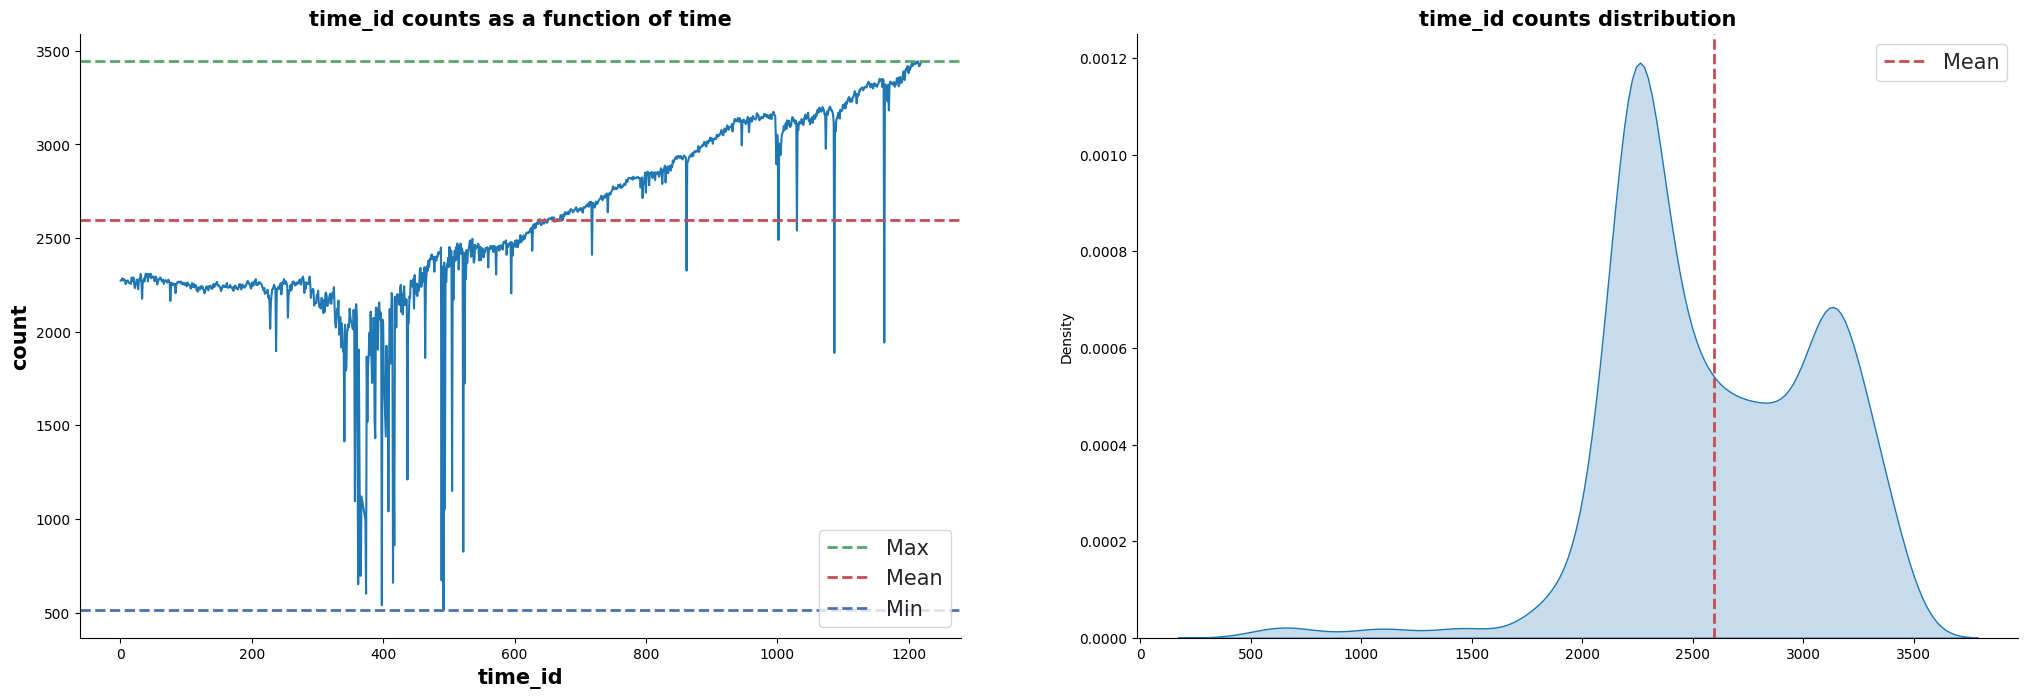

<Figure size 1440x720 with 0 Axes>


 time_id count
 -------------
	 unique count : 1211
	 mean : 2594.0627580511973
	 max : 3445
	 min : 512


In [19]:
time_ids = train_df.groupby("time_id").size() # 그룹별로 묶은 후, 갯수를 반환

fig, axes = plt.subplots(ncols= 2, figsize=(25, 8), dpi = 100) # 그래프의 행과 열, 그리고 해상도 지정
sns.set(style = "ticks", font_scale = 1) # 그래프의 스타일과 폰트 크기 지정
sns.despine(top=True, right=True, left=False, bottom=False) # 축, 테두리 지정
plt.figure(figsize = (20, 10))
sns.lineplot(data = time_ids, x = time_ids.index, y = time_ids.values, ax = axes[0]) # 그래프 종류 지정
axes[0].set_xlabel('time_id', fontsize = 15, weight = 'bold')
axes[0].set_ylabel('count', fontsize = 15, weight = 'bold')
axes[0].axhline(time_ids.values.max(), label="Max", color = "g", linewidth = 2, linestyle ="--") # 최대값 선 지정
axes[0].axhline(time_ids.values.mean(), label="Mean", color = "r", linewidth = 2, linestyle ="--") # 평균값 선 지정
axes[0].axhline(time_ids.values.min(), label="Min", color = "b", linewidth = 2, linestyle ="--") # 최소값 선 지정
axes[0].legend(prop={'size':15}, loc ='lower right') # 범례 지정
axes[0].set_title('time_id counts as a function of time',fontsize = 15, weight = 'bold')

sns.kdeplot(time_ids, fill = True, ax = axes[1]) # 그래프 종류 지정
axes[1].axvline(time_ids.values.mean(), label="Mean", color = "r", linewidth = 2, linestyle ="--") # 평균값 선 지정
axes[1].legend(prop={'size':15}, loc ='upper right')
axes[1].set_title('time_id counts distribution',fontsize = 15, weight = 'bold')
plt.show()

print("\n time_id count\n",'-'*len(str('time_id count')))
print(f"\t unique count : {len(train_df['time_id'].unique())}") # 고유 개수 출력
print(f"\t mean : {time_ids.values.mean()}") # 평균값 출력
print(f"\t max : {time_ids.values.max()}") # 최대값 출력
print(f"\t min : {time_ids.values.min()}") # 최소값 출력


#### time_id의 그래프
    - 고유 개수 : 1211 개
    - 평균값 : 2594.0627580511973
    - 거래 시간 수 최대값 : 3445
    - 거래 시간 수 최소값 : 512
- 왼쪽 그래프의 경우, 전체적으로 상승하는 경향이 보이고, time_id 350 ~ 600 에서 급격한 변화들이 있어, 모델 훈련에 영향이 있을 것으로 생각됨
- 오른쪽 그래프의 경우, time_id 1700 이후 거래가 급격하게 상승하기 시작하였고, 구간 2000 ~ 2500, 3000 ~ 3500 에 거래가 몰려있다는 것을 알 수 있음. 

### 2. investment_id

- investment_id에서 가장 많이 투자를 한 id와 가장 적게 출력을 한 id를 출력
    - 가장 많이 투자한 investment_id : 2140
    - 가장 적게 투자한 investment_id : 1415

In [20]:
inv_id = train_df.groupby(['investment_id']).size()
print(f"Number of unique investment_id's : {len(train_df['investment_id'].unique())}\n")
print(f"Index of investment_id with most entries : {inv_id.idxmax()}") 
print(f"Index of investment_id with least entries : {inv_id.idxmin()}") 

Number of unique investment_id's : 3579

Index of investment_id with most entries : 2140
Index of investment_id with least entries : 1415


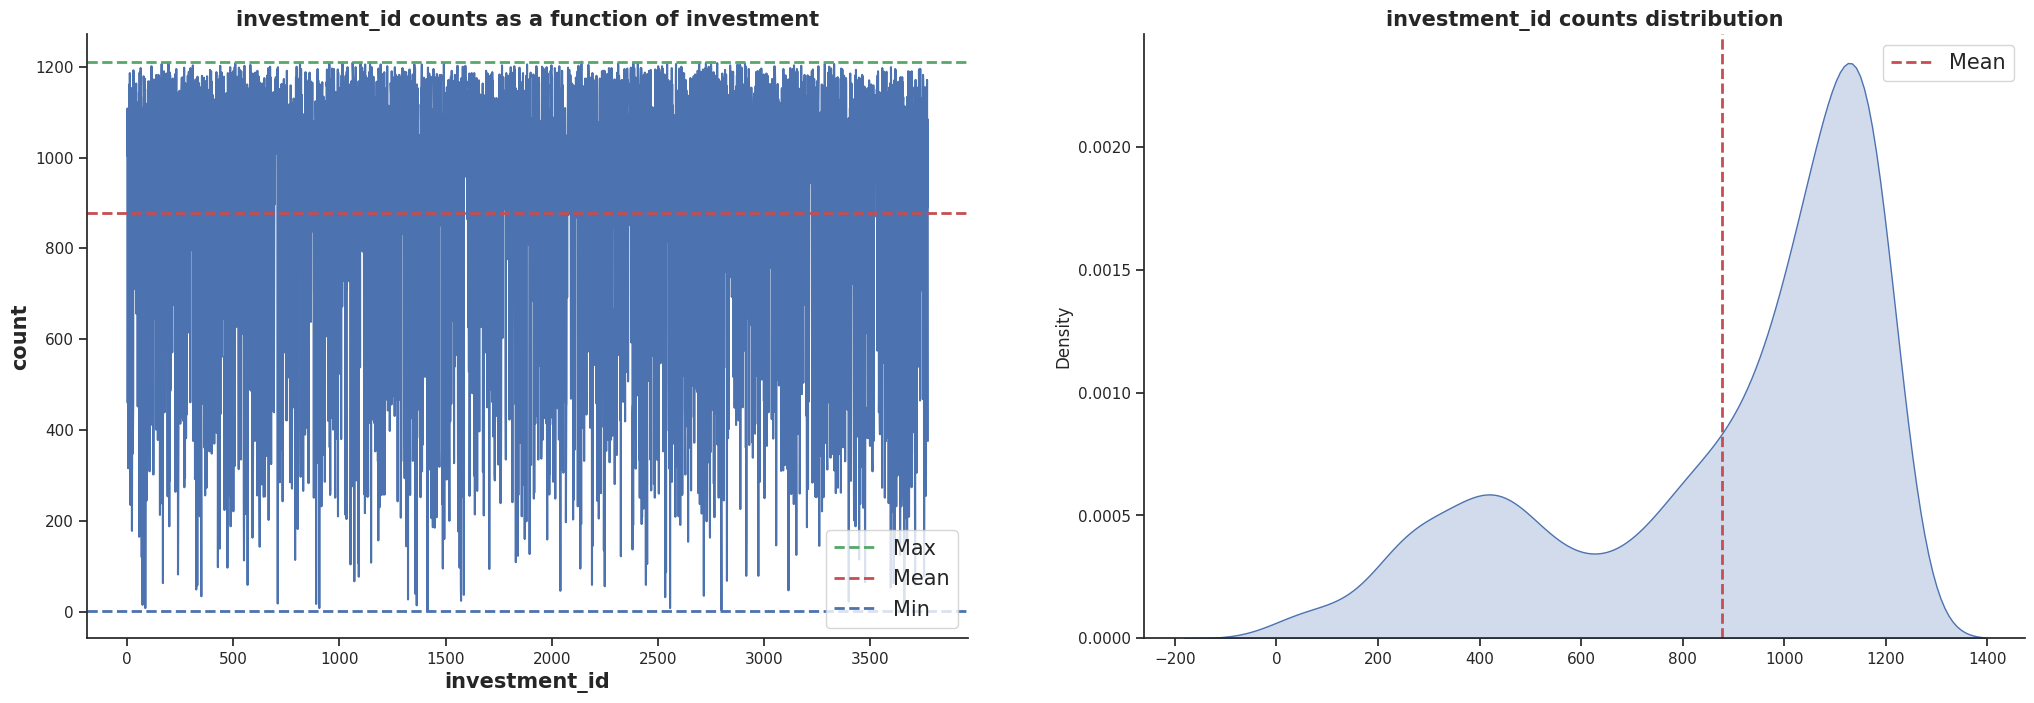

<Figure size 1440x720 with 0 Axes>


 investment_id count
 -------------------
	 unique count : 3579
	 mean : 877.7340039117072
	 max : 1211
	 min : 2


In [21]:
fig, axes = plt.subplots(ncols= 2, figsize=(25, 8), dpi = 100)
sns.set(style = "ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.figure(figsize = (20, 10))
sns.lineplot(data = inv_id, x = inv_id.index, y = inv_id.values, ax = axes[0])
axes[0].set_xlabel('investment_id', fontsize = 15, weight = 'bold')
axes[0].set_ylabel('count', fontsize = 15, weight = 'bold')
axes[0].axhline(inv_id.values.max(), label="Max", color = "g", linewidth = 2, linestyle ="--")
axes[0].axhline(inv_id.values.mean(), label="Mean", color = "r", linewidth = 2, linestyle ="--")
axes[0].axhline(inv_id.values.min(), label="Min", color = "b", linewidth = 2, linestyle ="--")
axes[0].legend(prop={'size':15}, loc ='lower right')
axes[0].set_title('investment_id counts as a function of investment',fontsize = 15, weight = 'bold')

sns.kdeplot(inv_id, fill = True, ax = axes[1])
axes[1].axvline(inv_id.values.mean(), label="Mean", color = "r", linewidth = 2, linestyle ="--")
axes[1].legend(prop={'size':15}, loc ='upper right')
axes[1].set_title('investment_id counts distribution',fontsize = 15, weight = 'bold')
plt.show()

print("\n investment_id count\n",'-'*len(str('investment_id count')))
print(f"\t unique count : {len(train_df['investment_id'].unique())}")
print(f"\t mean : {inv_id.values.mean()}")
print(f"\t max : {inv_id.values.max()}")
print(f"\t min : {inv_id.values.min()}")


#### investment_id의 그래프
    - 고유 개수 : 3579 개
    - 평균 투자 값 : 877.7340039117072
    - 투자 횟수 최대값 : 1211
    - 투자 횟수 최소값 : 2
- 오른쪽 그래프의 경우, investment_id의 순서에 관계없이 id별로 투자횟수가 다르다는 것을 알 수 있음.
- 왼쪽 그래프의 경우, time_id의 순서로 투자 밀도를 나타낸 그래프.
    - 전체적으로 투자 횟수가 늘어나는 경향.
    - 구간 200 ~ 600, 700 ~ 1200에 투자횟수가 증가함을 보임.

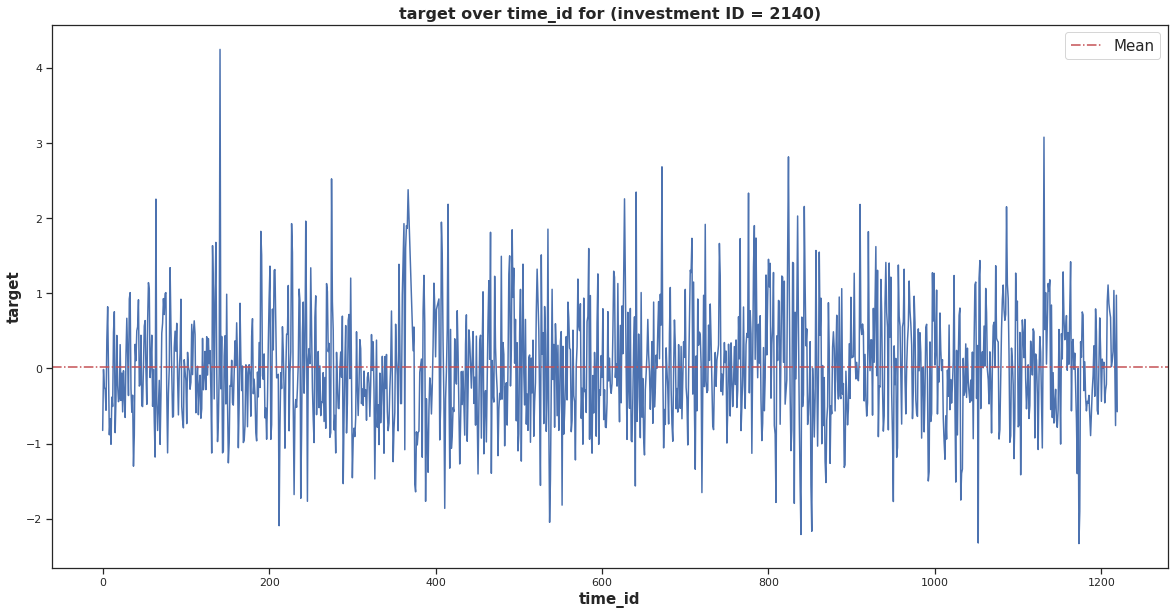


 investment_id = 2140
 --------------------
	transactions count : 1211
	mean : 0.014999


In [22]:
# investment_id = 2140
id_2140 = train_df[train_df['investment_id'] == 2140]
mean = round(id_2140['target'].mean(), 3)
plt.figure(figsize = (20, 10))
sns.set(style = 'ticks', font_scale = 1)
ax = sns.lineplot(data = id_2140, x = 'time_id', y = 'target')
ax.axhline(mean,label = 'Mean', color = 'r', linestyle = '-.')
ax.legend(prop={'size':15}, loc='upper right')
ax.set_xlabel('time_id',fontsize = 15,weight = 'bold')
ax.set_ylabel('target',fontsize = 15,weight = 'bold')
plt.title('target over time_id for (investment ID = 2140)',fontsize = 16,weight = 'bold');
plt.show()

print("\n investment_id = 2140\n",'-'*len(str('investment_id = 2140')))
print(f"\ttransactions count : {inv_id.values.max()}")
print(f"\tmean : {mean:.6f}")


### investment_id == 2140 의 그래프
    - transcation 횟수 : 1211
    - target의 평균 값 : 0.014999
- continuous한 모습을 보여 예측에 유리할 것으로 보임.

### 3. target

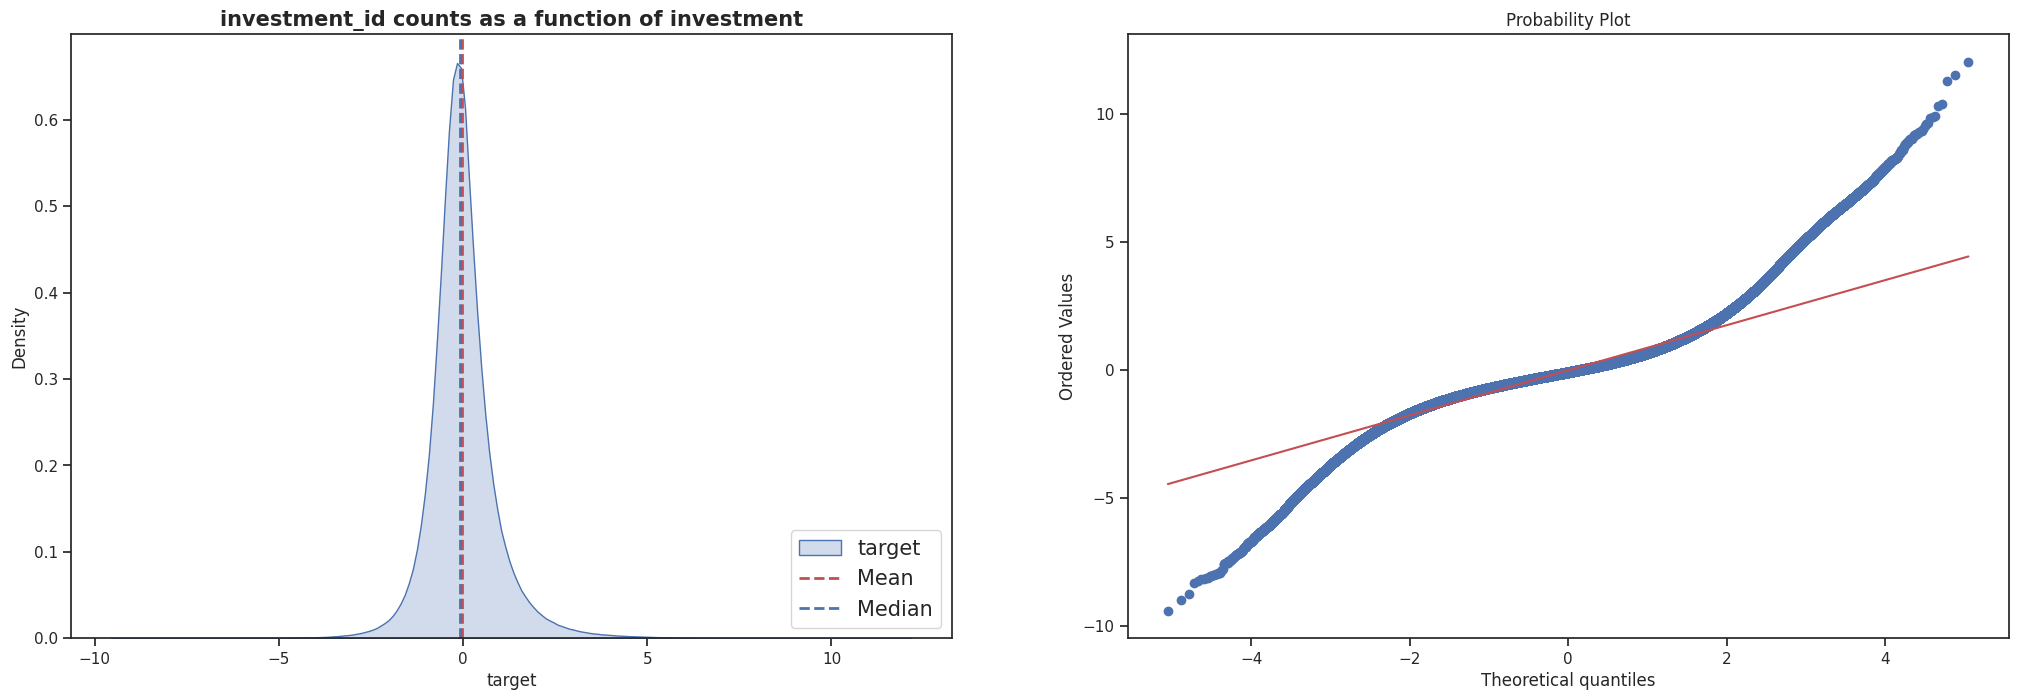


 target 
 ------
	 mean : -0.021092
	 max : 12.0390625
	 min : -9.421875


In [23]:
fig, axes = plt.subplots(ncols= 2, figsize=(25, 8), dpi = 100)
sns.set(style = "ticks", font_scale = 1)
sns.kdeplot(train_df['target'], label = "target", fill = True, ax = axes[0])
axes[0].axvline(train_df['target'].astype(np.float32).mean(), label="Mean", color = "r", linewidth = 2, linestyle ="--")
axes[0].axvline(train_df['target'].median(), label="Median", color = "b", linewidth = 2, linestyle ="--")
axes[0].legend(prop={'size':15}, loc ='lower right')
axes[0].set_title('investment_id counts as a function of investment',fontsize = 15, weight = 'bold')

stats.probplot(train_df['target'], plot=axes[1])

plt.show()

print("\n target \n",'-'*len(str('target')))
print(f"\t mean : {train_df['target'].astype(np.float32).mean():.6f}")
print(f"\t max : {train_df['target'].max()}")
print(f"\t min : {train_df['target'].min()}")


#### target의 그래프
    - 평균값 : -0.021092
    - 최대값 : 12.0390625
    - 최소값 : -9.421875
- 평균값이 0에 아주 가깝고, 대칭성을 보아 정규화가 잘되어있은 것으로 보임.
- 첨도가 높고, 양 끝 값과 0사이 거리가 길다는 것을 확인.

### 4. features

- 300개가 있으므로 일일이 확인하는 것이 어려움.
- 25개를 골라 밀도함수로 표현
- 각 f_별로 특징들이 들어남. 

  0%|          | 0/25 [00:00<?, ?it/s]

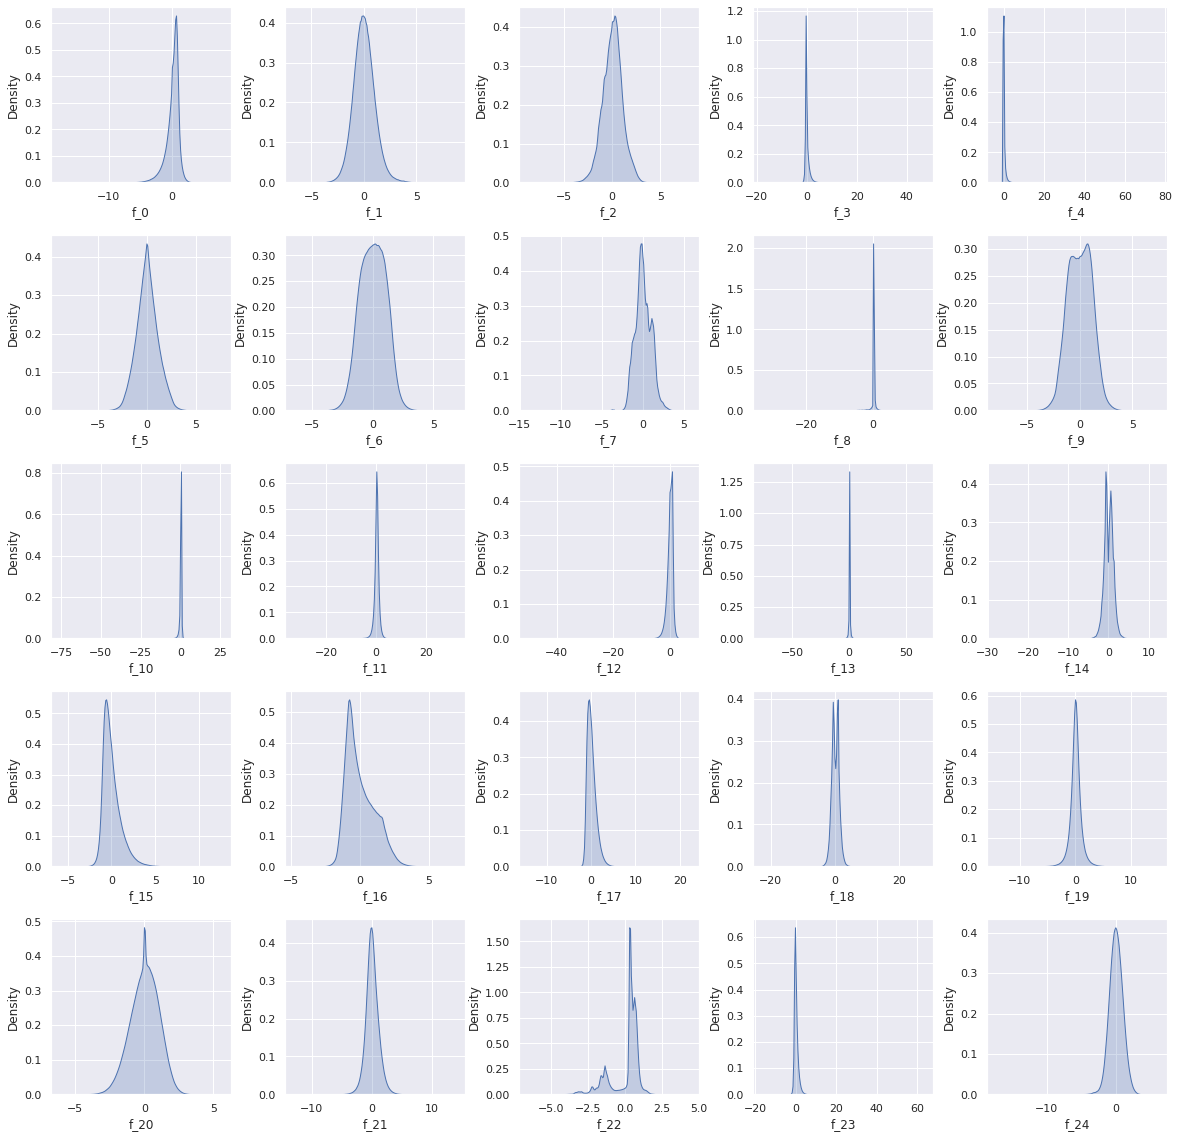

In [24]:
plt.figure(figsize=(20, 20))
sns.set(font_scale=1)
for i in tqdm(range(0, 25)): # 처리에 시간이 걸려 진행상황 확인 기능 추가
    plt.subplot(5, 5, i+1)
    plt.subplots_adjust(wspace=0.3, hspace=0.3) # 그래프간 간격 설정
    sns.kdeplot(train_df[f"f_{i}"], fill = True)

plt.show()

# 다음 과정
https://www.kaggle.com/blackjjw/ubiquant-2/edit   

### References
https://www.kaggle.com/code/yoshikuwano/fast-read-data-and-memory-optimization/notebook   
https://www.kaggle.com/code/rohanrao/tutorial-on-reading-large-datasets/notebook#Format:-csv    
https://www.kaggle.com/code/sytuannguyen/ubiquant-data-preparation#3.-Save-the-reduced-dataframe   
https://www.kaggle.com/code/jnegrini/ubiquant-eda   
https://www.kaggle.com/code/gunesevitan/ubiquant-market-prediction-eda/notebook#3.-Target   
https://www.kaggle.com/code/ilialar/ubiquant-eda-and-baseline#Features   
